# How does Speech Recognition work?

Let's take a moment to talk about how Speech Recognition works. Speech Recognition has been around for decades, so why is it just now hitting the mainstream? The reason is that deep learning finally made Speech Recognition accurate enough. A full discussion would fill a book, so we won’t bore you with all of the technical details here.

## 1. Turning Sounds into Bits

The first step in Speech Recognition is obvious — we need to feed sound waves into a computer. As we've already learned, an image can be seen as an array of numbers so that we can feed it directly into a neural network for image recognition:

<img src="./resources/8.png"  style="height: 250px"/>

But sound is transmitted as waves. How do we turn sound waves into numbers so that it can be used as input for a neural network?

<img src="./resources/SR.png"  style="height: 150px"/>

First let's install the Python library playsound. The module contains only one thing - the function (also named) playsound. It requires one argument - the path to the file with the sound you’d like to play. 

In [1]:
pip install playsound==1.2.2

  Using cached playsound-1.2.2-py2.py3-none-any.whl (6.0 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
file = 'hello_male_mono.wav'
fullname = 'resources/' + file

from playsound import playsound

playsound(fullname)

Let’s have a look at the sound clip of someone saying "Hello":

<img src="./resources/hello.png"  style="height: 200px"/>

Sound waves are one-dimensional. At every moment in time, they have a single value based on the height of the wave. Let’s zoom in on one tiny part of the sound wave and take a look:

<img src="./resources/wave.png"  style="height: 200px"/>

To turn this sound wave into numbers, we use *sampling*: we just record the height of the wave at equally-spaced points in time (thousands of times a second):

<img src="./resources/sampling.gif"  style="height: 200px"/>

This means that we are inspecting the wave __thousands of times a second__ and recording a number representing the height of the sound wave at that point in time. That’s basically all an uncompressed .wav audio file is. *CD Quality* audio is sampled at 44.1khz (44,100 readings per second). But for Speech Recognition, a sampling rate of 16khz (16,000 samples per second) is enough to cover the frequency range of human speech.

Let's sample our "Hello" sound wave 16,000 times per second. Here are the first 100 samples. Each number represents the amplitude (= height) of the sound wave at 1/16000th of a second intervals:

<img src="./resources/sample.png"  style="height: 75px"/>

We can use matplotlib (pyplot) to plot the sound wave for our .wav-file. As you can see, our .wav-file is sampled at 44.1khz.

Sampling Frequency: 44100
Number of samples: 17658
Length of hello_male_mono.wav: 0.4 seconds

[ -9  33  30  -3  51  26   1  50   7   8  50  -2  20  43 -10  33  32 -13
  37  16  -6  46   6   4  50   1  20  46  -7  29  33 -11  40  22  -7  44
   3   0  45  -6  15  46  -8  31  41  -6  44  25  -5  44   5  -5  43  -4
   7  36 -17  18  27 -23  24  10 -20  33  -3 -14  32 -20  -8  26 -26  11
  22 -22  30  20  -9  44  11   1  49   3  13  46  -9  19  32 -20  30  21
 -13  41  10  -2  48   4  15  49  -4  29]


Text(0, 0.5, 'Amplitude')

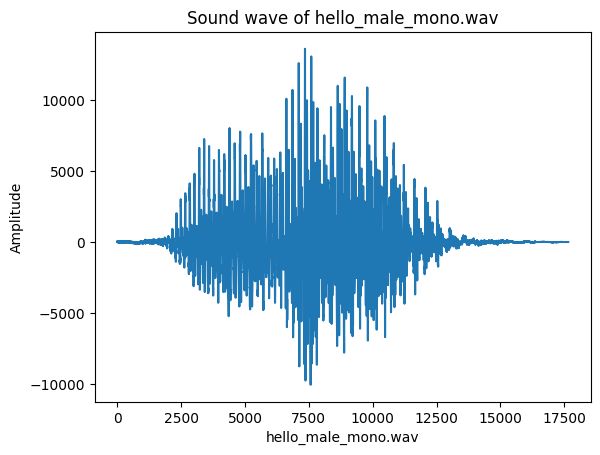

In [3]:
# import the pyplot and wavfile modules 
import matplotlib.pyplot as plot
from scipy.io import wavfile

# read the wav file (mono)
samplingFrequency, signalData = wavfile.read(fullname)

print('Sampling Frequency: ' + str(samplingFrequency))
print('Number of samples: ' + str(len(signalData)))
print('Length of ' + file + ': ' + str(round(len(signalData)/samplingFrequency,2)) + ' seconds\n')

# print the first 100 amplitudes
print(signalData[:100])

# plot the signal read from wav file
plot.title('Sound wave of ' + file)
plot.plot(signalData)
plot.xlabel(file)
plot.ylabel('Amplitude')

## 2. Pre-processing our Sampled Sound Data

We now have an array of numbers with each number representing the sound wave’s amplitude at 1/16,000th of a second intervals.
We could feed these numbers right into a neural network. But trying to recognize speech patterns by processing these samples directly is difficult. It's almost the same as with images: if we flatten a big image right away, we need a really big input layer. That's why we used convolutions, to transform the input into something more easily analysed. We'll do something similar with this speech pattern, so we'll be doing some pre-processing on the audio data.

Let’s start by grouping our sampled audio into 20-millisecond-long chunks. Here’s our first 20 milliseconds of audio (i.e., our first 320 samples):

<img src="./resources/20ms.png"  style="height: 200px"/>

Plotting those numbers as a simple line graph gives us a rough approximation of the original sound wave for that 20 millisecond period of time:

<img src="./resources/20msg.png"  style="height: 200px"/>

This recording is only 1/50th of a second (20 milliseconds) long. But even this short recording is a complex mish-mash of different frequencies of sound. There are some low sounds, some mid-range sounds, and even two peaks of high-pitched sounds sprinkled in. Taken all together, these different frequencies mix together to make up the complex sound of human speech.

You can compare the complex mish-mash of different frequencies with someone playing a C Major chord on a piano. That sound is the combination of three musical notes — C, E and G — all mixed together into one complex sound.

Now the idea is to break apart the complex sound wave into the simple sound waves that make it up. Once we have those individual sound waves, we add up how much energy is contained in each one. We do this using a mathematical operation called a **(Fast) Fourier Transformation**.

The end result is a score of how important each frequency range is, from low pitch (i.e. bass notes) to high pitch. Each number below represents how much energy was in each 50hz band of our 20 millisecond audio clip. There are 160 numbers in the result (8000hz divided into frequency ranges of 50hz):

<img src="./resources/ft.png"  style="height: 200px"/>

This is a lot easier to see when you draw this as a chart. You can see that our 20 millisecond sound snippet has a lot of low-frequency energy and not much energy in the higher frequencies. That’s typical of "male" voices:

<img src="./resources/ft20ms.png"  style="height: 100px"/>

If we repeat this process on every 20 millisecond chunk of audio, we end up with a spectrogram (each column from left-to-right is one 20ms chunk):

<img src="./resources/all.png"  style="height: 400px"/>

A spectrogram is cool because you can actually see musical notes and other pitch patterns in audio data. A neural network can find patterns in this kind of data more easily than raw sound waves. So this is the data representation we’ll actually feed into our neural network. Since a spectrogram almost looks like a normal image, we can use a **Convolutional Neural Network** to perform the classification task.

To finish this Notebook, let's plot the spectrogram for our .wav-file.

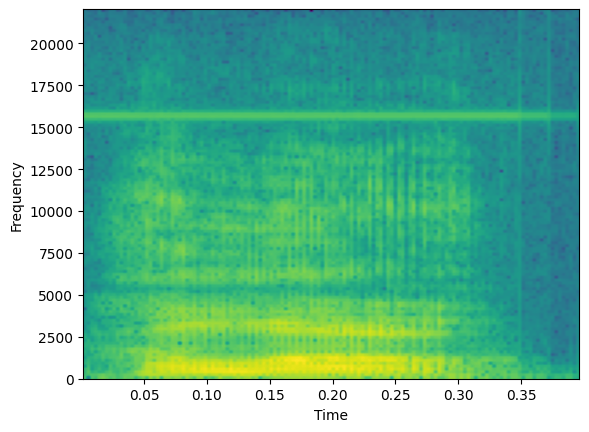

In [4]:
plot.specgram(signalData,Fs=samplingFrequency)

plot.xlabel('Time')
plot.ylabel('Frequency')
plot.show()

## Exercise

Download a .wav-file (or record one yourself) and try to visualize the sound wave. Plot the spectrogram (you need to convert the .wav-file to mono first).